## Perceptron — End-to-End Workflow (Binary, Linearly Separable Data)

This notebook builds a full supervised binary classification pipeline using the classic Perceptron:
	•	Data Exploration: generate, inspect, visualize a (nearly) linearly separable dataset
	•	Preprocessing: stratified split, (optional) scaling
	•	Modeling: from-scratch Perceptron + scikit-learn Perceptron, plus a Logistic Regression baseline
	•	Evaluation: accuracy, precision/recall/F1, confusion matrix, decision regions

Perceptron vs. MLP: Perceptron is a single linear layer with a step activation and converges only on linearly separable data. MLPs add hidden layers + nonlinearities (e.g., ReLU) and can model nonlinear boundaries.

## Setup

In [9]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, Dict, List
from IPython.display import display

# sklearn utilities
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.5, 4.0)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll create a 2D, almost linearly separable dataset so we can visualize decision boundaries.

Shape: (800, 3)


,x1,x2,target
0,-1.640160,1.819302,0
1,-1.417757,1.192284,0
2,-0.094163,0.859296,0
3,1.635465,1.753193,1
4,-2.553169,2.401495,0


,x1,x2,target
count,800.000000,800.000000,800.000000
mean,-0.009021,1.973298,0.497500
std,2.188338,0.573789,0.500307
min,-5.427636,-0.044764,0.000000
25%,-1.935439,1.632377,0.000000
50%,0.248378,1.983703,0.000000
75%,1.995762,2.291231,1.000000
max,4.852476,4.226710,1.000000


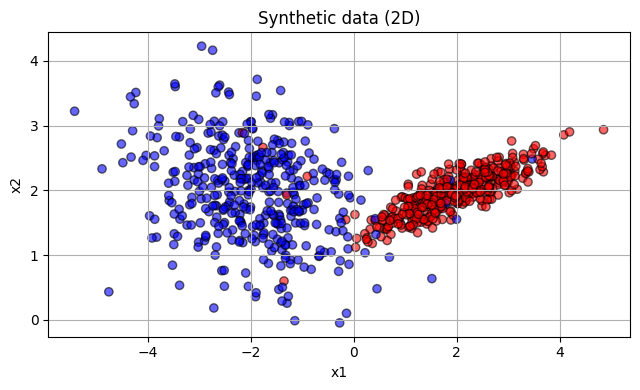


Class counts:


target
0    402
1    398
Name: count, dtype: int64

In [10]:
# Generate a (nearly) linearly separable 2D dataset
X, y = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,       # bigger = more separable
    flip_y=0.02,         # small label noise
    random_state=42
)

df = pd.DataFrame(X, columns=["x1", "x2"])
df["target"] = y

print("Shape:", df.shape)
display(df.head())
display(df.describe())

# Quick scatter plot
plt.scatter(df["x1"], df["x2"], c=df["target"], cmap="bwr", alpha=0.6, edgecolor="k")
plt.title("Synthetic data (2D)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout(); plt.show()

print("\nClass counts:")
display(df["target"].value_counts())

## Preprocessing

We’ll do a stratified split. Perceptron doesn’t require scaling, but it often converges faster with standardized features, so we’ll include scaling in pipelines.

In [11]:
# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    df[["x1", "x2"]], df["target"], test_size=0.25, stratify=df["target"], random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))

Train: (600, 2)  Test: (200, 2)
Train class balance:
 target
0    0.501667
1    0.498333
Name: proportion, dtype: float64


## Modeling

We’ll train:
	1.	From-scratch Perceptron (step activation, online updates on mistakes)
	2.	sklearn Perceptron in a Pipeline(StandardScaler → Perceptron)
	3.	Logistic Regression baseline (to compare a probabilistic linear classifier)

In [12]:
class SimplePerceptron:
    """
    Classic binary perceptron (for teaching).
    - Labels are internally mapped to {-1, +1}
    - Online updates on misclassified points: w <- w + lr * y * x, b <- b + lr * y
    - fit_intercept=True uses a separate bias term
    """
    def __init__(self, lr: float = 1.0, max_iter: int = 1000, shuffle: bool = True, fit_intercept: bool = True, random_state: Optional[int] = 42):
        self.lr = float(lr)
        self.max_iter = int(max_iter)
        self.shuffle = bool(shuffle)
        self.fit_intercept = bool(fit_intercept)
        self.random_state = random_state

        self.coef_: Optional[np.ndarray] = None  # (d,)
        self.intercept_: float = 0.0
        self.classes_: Optional[np.ndarray] = None

    @staticmethod
    def _sign(z: np.ndarray) -> np.ndarray:
        # Perceptron convention: sign(0) -> +1
        out = np.ones_like(z, dtype=int)
        out[z < 0] = -1
        return out

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        n, d = X.shape

        # Map labels to {-1, +1}
        self.classes_ = np.unique(y)
        assert self.classes_.size == 2, "This simple implementation is binary only."
        y_map = np.where(y == self.classes_[0], -1, +1)  # classes_[0] -> -1, classes_[1] -> +1

        rng = np.random.RandomState(self.random_state)
        self.coef_ = np.zeros(d, dtype=float)
        self.intercept_ = 0.0

        idx = np.arange(n)
        for _ in range(self.max_iter):
            if self.shuffle:
                rng.shuffle(idx)
            errors = 0
            for i in idx:
                xi = X[i]
                yi = y_map[i]
                z = np.dot(self.coef_, xi) + (self.intercept_ if self.fit_intercept else 0.0)
                pred = +1 if z >= 0 else -1
                if pred != yi:
                    # update on mistakes
                    self.coef_ += self.lr * yi * xi
                    if self.fit_intercept:
                        self.intercept_ += self.lr * yi
                    errors += 1
            if errors == 0:
                break
        return self

    def decision_function(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        return X @ self.coef_ + (self.intercept_ if self.fit_intercept else 0.0)

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        z = self.decision_function(X)
        # map back to original labels
        signs = np.where(z >= 0, +1, -1)
        return np.where(signs == -1, self.classes_[0], self.classes_[1])

In [13]:
from sklearn.preprocessing import StandardScaler

scaler_scratch = StandardScaler()
X_train_s = scaler_scratch.fit_transform(X_train)
X_test_s  = scaler_scratch.transform(X_test)

# 1) From-scratch perceptron
perc_scratch = SimplePerceptron(lr=1.0, max_iter=2000, shuffle=True, fit_intercept=True, random_state=42)
perc_scratch.fit(X_train_s, y_train)

# 2) sklearn perceptron with scaling
perc_sklearn = Pipeline([
    ("scaler", StandardScaler()),
    ("perc", Perceptron(
        penalty=None,          # try None or 'l2'
        alpha=0.0001,
        max_iter=1000,
        tol=1e-4,
        eta0=1.0,
        fit_intercept=True,
        shuffle=True,
        random_state=42
    ))
])
perc_sklearn.fit(X_train, y_train)

# 3) Logistic Regression baseline (scaled)
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty="l2", C=1.0, solver="lbfgs", max_iter=2000, random_state=42
    ))
]).fit(X_train, y_train)

## Hyperparameter Tuning (sklearn perceptron)

We’ll sweep a small grid for penalty strength and learning rate.

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=Pipeline([
        ("scaler", StandardScaler()),
        ("perc", Perceptron(max_iter=1000, tol=1e-4, random_state=42))
    ]),
    param_grid={
        "perc__penalty": [None, "l2"],
        "perc__alpha": [1e-4, 1e-3, 1e-2],
        "perc__eta0": [0.1, 1.0, 2.0],
        "perc__fit_intercept": [True, False],
    },
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
perc_best = grid.best_estimator_

Best params: {'perc__alpha': 0.001, 'perc__eta0': 2.0, 'perc__fit_intercept': False, 'perc__penalty': 'l2'}
Best CV accuracy: 0.9650000000000001


## Evaluation

We’ll compute accuracy, precision, recall, F1, and a confusion matrix for each model.
We’ll also plot decision regions (2D) for visual intuition.

In [15]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import numpy as np
import pandas as pd

def safe_classification_report(y_true, y_pred, target_names=None):
    # zero_division=0 prevents UndefinedMetricWarning when a class is never predicted
    return classification_report(
        y_true, y_pred, target_names=target_names, zero_division=0
    )

def evaluate_binary(name: str, model, X_te, y_te, target_names=None):
    y_pred = model.predict(X_te)
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec  = recall_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification report:\n", safe_classification_report(y_te, y_pred, target_names=target_names))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def inspect_missing_predictions(y_true, y_pred):
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    missing = np.setdiff1d(true_labels, pred_labels)
    print("True labels:", true_labels)
    print("Predicted labels:", pred_labels)
    print("Labels never predicted:", missing if missing.size else "None ✅")

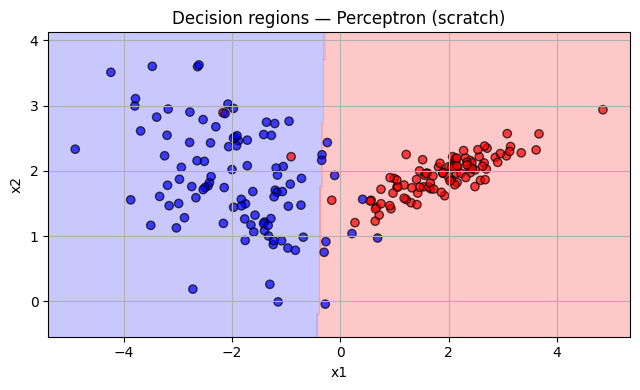

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


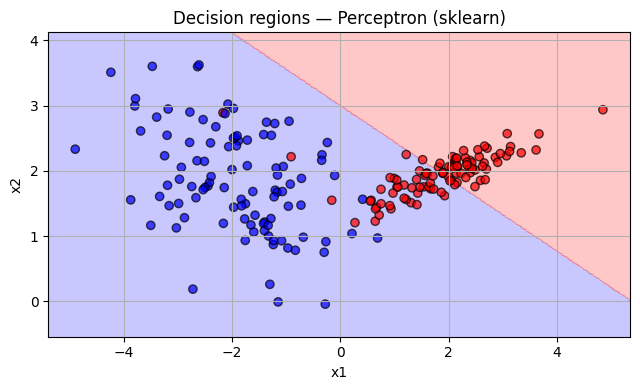

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


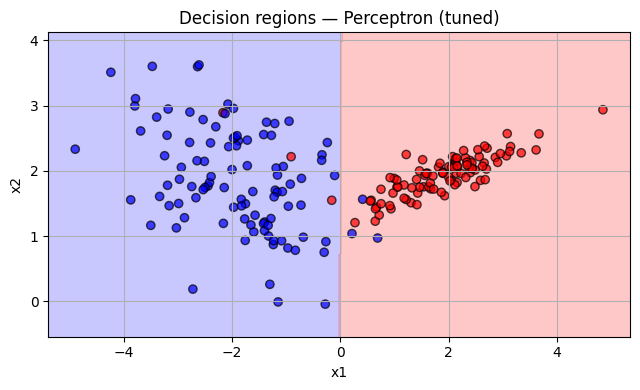

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


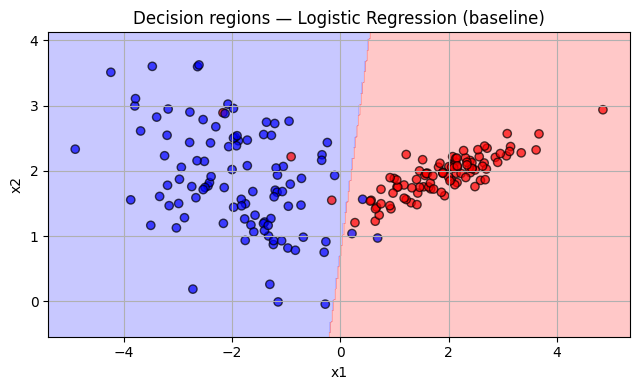

In [16]:
# 2D decision region plotting
def plot_decision_regions_2d(model, X2: pd.DataFrame, y2: pd.Series, title: str):
    X_np = X2.to_numpy()
    y_np = y2.to_numpy()

    # If model is a pipeline w/ scaler, we can fit a clone; here assume already fit.
    x1_min, x1_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    x2_min, x2_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x1_min, x1_max, 400),
        np.linspace(x2_min, x2_max, 400),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25, cmap="bwr")
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap="bwr", edgecolor="k", alpha=0.7)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.title(title)
    plt.tight_layout(); plt.show()

plot_decision_regions_2d(perc_scratch, X_test, y_test, "Decision regions — Perceptron (scratch)")
plot_decision_regions_2d(perc_sklearn, X_test, y_test, "Decision regions — Perceptron (sklearn)")
plot_decision_regions_2d(perc_best, X_test, y_test, "Decision regions — Perceptron (tuned)")
plot_decision_regions_2d(logreg, X_test, y_test, "Decision regions — Logistic Regression (baseline)")

## Key Takeaways
	•	The Perceptron learns a linear decision boundary with a step activation. It converges only if the training data are linearly separable (otherwise it may cycle).
	•	Scaling can speed convergence; shuffling and learning rate (eta0 / lr) affect stability.
	•	It does not produce probabilities; for calibrated probabilities use Logistic Regression or SVM (Platt scaling).
	•	Useful as a baseline or online learner; for nonlinear boundaries consider MLP (with hidden layers) or kernel methods.